In [1]:
import torch
from diffusers import StableDiffusion3Pipeline
import diffusers


# model_id = "stabilityai/stable-diffusion-3-medium-diffusers"
model_id = "/storage/ms5267@drexel.edu/models/stable-diffusion-3-medium-diffusers/models--stabilityai--stable-diffusion-3-medium-diffusers/snapshots/ea42f8cef0f178587cf766dc8129abd379c90671"
pipe = StableDiffusion3Pipeline.from_pretrained(model_id, torch_dtype=torch.float16)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [2]:
from diffusers.utils.transformer_split_config import TransformerSplitConfig
    
# transformer_split1_host = '96.245.177.234'
# transformer_split1_port = 8765

# transformer_split2_host = '96.245.177.234' 
# transformer_split2_port = 8766

transformer_split1_host = ['0.0.0.0','0.0.0.0']
transformer_split1_port = [1234, 8765]

transformer_split2_host = ['0.0.0.0','0.0.0.0']
transformer_split2_port = [5678, 9876]

# Create an instance of TransformerSplitConfig
split_config = TransformerSplitConfig(
    num_splits=2,
    hosts=[transformer_split1_host, transformer_split2_host],
    ports=[transformer_split1_port, transformer_split2_port],
    pipe_config=pipe.transformer.config,
    enable_work_validation=True
)



In [3]:
pipe.transformer.config

FrozenDict([('sample_size', 128),
            ('patch_size', 2),
            ('in_channels', 16),
            ('num_layers', 24),
            ('attention_head_dim', 64),
            ('num_attention_heads', 24),
            ('joint_attention_dim', 4096),
            ('caption_projection_dim', 1536),
            ('pooled_projection_dim', 2048),
            ('out_channels', 16),
            ('pos_embed_max_size', 192),
            ('_class_name', 'SD3Transformer2DModel'),
            ('_diffusers_version', '0.29.0.dev0'),
            ('_name_or_path',
             '/storage/ms5267@drexel.edu/models/stable-diffusion-3-medium-diffusers/models--stabilityai--stable-diffusion-3-medium-diffusers/snapshots/ea42f8cef0f178587cf766dc8129abd379c90671/transformer')])

In [4]:
from diffusers import StableDiffusion3PipelineSplitClientSocket

from diffusers.models.transformers.transformer_sd3_split import SD3Transformer2DModelClientSplit


part1_blocks = pipe.transformer.transformer_blocks[0]

time_text_embed_state_dict = pipe.transformer.time_text_embed.state_dict()
context_embedder_state_dict = pipe.transformer.context_embedder.state_dict()
pos_embed_state_dict = pipe.transformer.pos_embed.state_dict()

transformer_client_split = SD3Transformer2DModelClientSplit(pipe.transformer.config, part1_blocks, time_text_embed_state_dict, context_embedder_state_dict, pos_embed_state_dict).half()

split_pipe = StableDiffusion3PipelineSplitClientSocket(
    	transformer_client_split =transformer_client_split,
    	transformer_server_split_config=split_config,

        scheduler = pipe.scheduler,
        vae = pipe.vae,
        text_encoder = pipe.text_encoder,
        tokenizer= pipe.tokenizer,
        text_encoder_2 = pipe.text_encoder_2,
        tokenizer_2=pipe.tokenizer_2,
        text_encoder_3=pipe.text_encoder_3,
        tokenizer_3= pipe.tokenizer_3,)

In [5]:
split_pipe = split_pipe.to("cuda:4")

  0%|          | 0/28 [00:00<?, ?it/s]

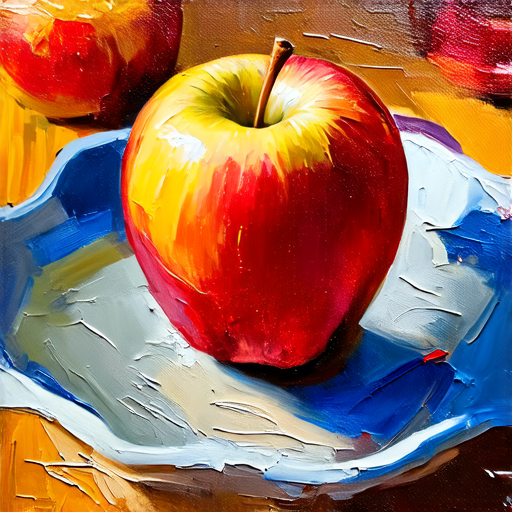

In [11]:
image = split_pipe(
    # "High quality portrait suited to put in LinkedIn of a anthromorphic bunny",
	"An painting of an apple in fruit tray in the style of van gogh",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    height = 512, 
    width = 512
).images[0]
image

In [8]:
pipe

StableDiffusion3Pipeline {
  "_class_name": "StableDiffusion3Pipeline",
  "_diffusers_version": "0.30.0.dev0",
  "_name_or_path": "/storage/ms5267@drexel.edu/models/stable-diffusion-3-medium-diffusers/models--stabilityai--stable-diffusion-3-medium-diffusers/snapshots/ea42f8cef0f178587cf766dc8129abd379c90671",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_3": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_3": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "SD3Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [7]:
noise = torch.load('/home/ms5267/blockentropy/models/noise_2.pth')

In [9]:
noise.shape

torch.Size([2, 16, 64, 64])

In [13]:
import torch
import matplotlib.pyplot as plt

def plot_tensor(noise):
	tensor = noise.detach().cpu()

	# Plot the tensor as an image
	plt.imshow(tensor, cmap='gray')
	plt.colorbar()  # Optional: adds a colorbar to the side
	# plt.title("Random Tensor Image")
	plt.show()


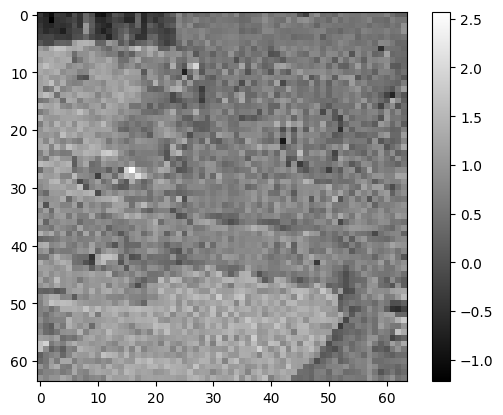

In [15]:
plot_tensor(noise[0][1])

In [16]:
output_intermediate = torch.load('/home/ms5267/blockentropy/models/output_intermediate.pth')
(hidden_states, encoder_hidden_states, temb, height_, width_) = output_intermediate

hidden_states.shape

torch.Size([2, 1024, 1536])

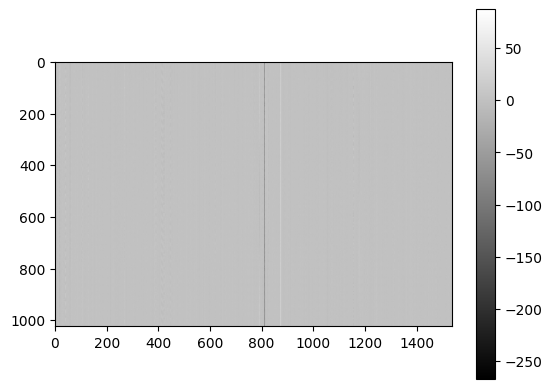

In [17]:

plot_tensor(hidden_states[1])

100


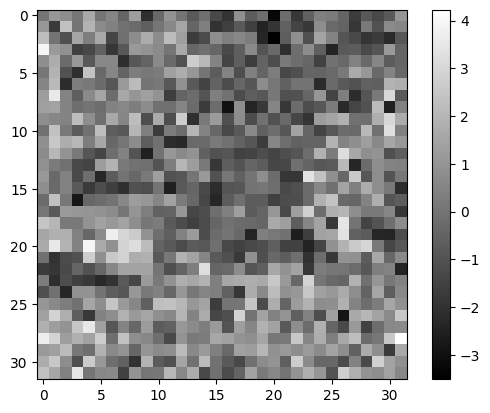

101


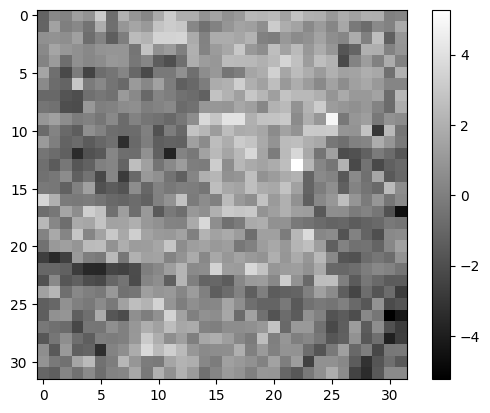

102


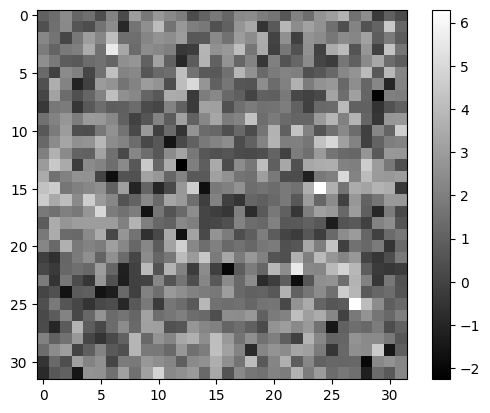

103


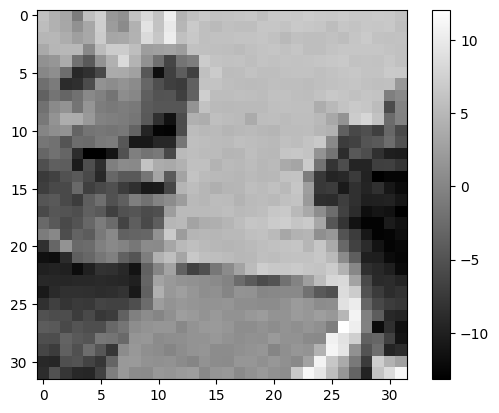

104


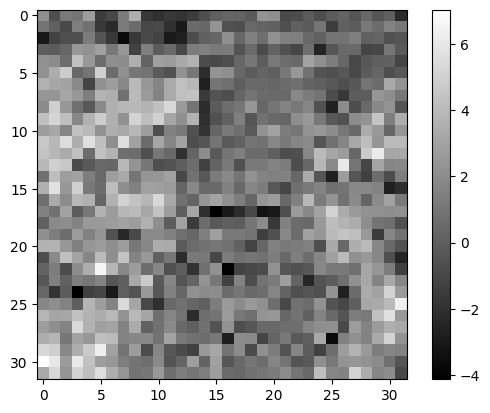

105


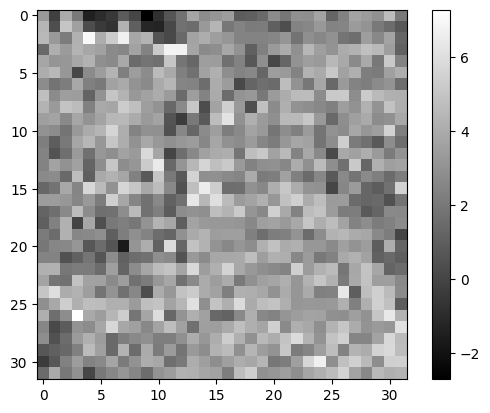

106


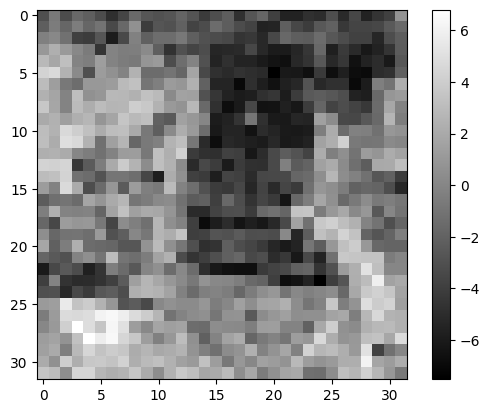

107


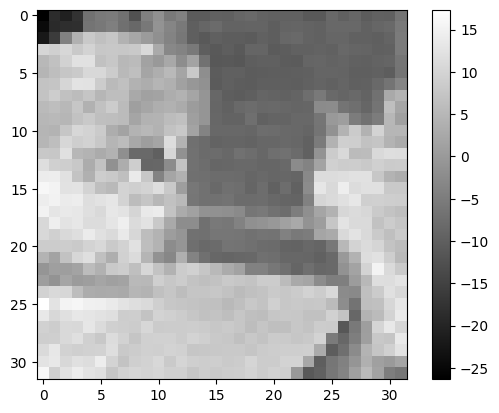

108


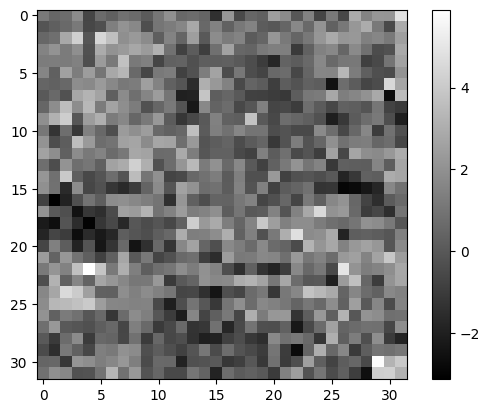

109


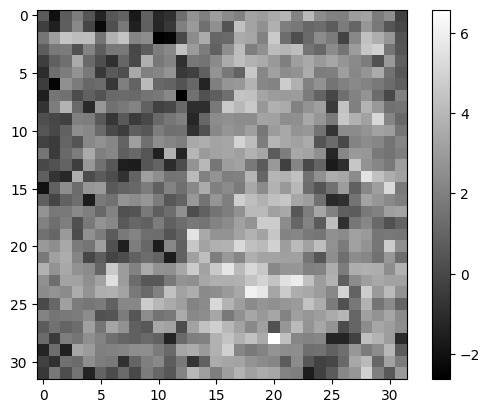

In [20]:
for i in range(100,110):
	print(i)
	plot_tensor(hidden_states[1][:,i].reshape(32,32))


In [22]:
encoder_hidden_states.shape

torch.Size([2, 333, 1536])